In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
from math import cos, sin, exp

%matplotlib inline  
sns.set()

## Examples

In [2]:
l = 1
t_inp = 1
a = 1
h = 0.1
tau = 0.1
mu_t = "3 * t"
g_x = "cos(3*x) - exp(2*x) + 2"

In [3]:
# l = 2
# t_inp = 2
# a = 1
# h = 0.2
# tau = 0.2
# mu_t = "4 * t"
# g_x = "exp(2*x) + sin(x**3)"

In [4]:
l_am = int(l / h)
t_am = int(t_inp / tau)

x = []
for i in range(l_am):
    x.append (i * h)
    
t = []
for i in range(t_am):
    t.append (i * tau)
    
xs = [x] * t_am

ys = []
for i in range(t_am):
    ys.append([t[i]] * l_am)

In [5]:
def func_g(x):
    return eval(g_x)


def func_mu(t):
    return eval(mu_t)

In [6]:
def three_diagonal_matrix(diag_a, 
                          diag_b, 
                          diag_c, 
                          function):
    n = len(diag_a)
    y = [0] * n
    
    c, d = [diag_c[0] / diag_b[0]], [function[0] / diag_b[0]]

    for i in range(1, n):
        c.append(diag_c[i] / (diag_b[i] - diag_a[i] * c[i - 1]))
        d.append((-diag_a[i] * d[i - 1] + function[i]) / (diag_b[i] - diag_a[i] * c[i - 1]))

    y[-1] = d[-1]

    for i in reversed(range(n - 1)):
#     for i in range(0, n-1, -1):
        y[i] = -c[i] * y[i + 1] + d[i]

    return y

In [7]:
def get_y_kh(l_am, t_am, a, tau, h):
    
    y = np.zeros((l_am, t_am))
    
    for i in range(l_am):
        y[0][i] = func_g(x[i])

    for i in range(t_am):
        y[i][0] = func_mu(t[i])
    
    k_h = a * tau / h
    
    return y, k_h

## Схема “Явний лівий кут”

In [8]:
def equation_16(a, tau, h, l_am, t_am, x, t):
    
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    
    for j in range(t_am - 1):
        for k in range(l_am - 1):
            y[j + 1][k] = -(k_h * y[j][k + 1]) + (k_h + 1) * y[j][k]

    return y

## Схема “Неявний лівий кут”

In [9]:
def equation_21(a, tau, h, l_am, t_am, x, t):

    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    
    for j in range(t_am - 1):
        for k in range(l_am - 1):
            y[j + 1][k + 1] = y[j + 1][k] - (y[j + 1][k] - y[j][k]) / k_h
    return y

## Явна схема з центральною різницею

In [10]:
def equation_22(a, tau, h, l_am, t_am, x, t):
    
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    
    for j in range(t_am - 1):
        for k in range(1, l_am - 1):
            y[j + 1][k] = y[j][k] - k_h * 0.5 * (y[j][k + 1] - y[j][k - 1])
        y[j + 1][t_am - 1] = (k_h * (y[j + 1][l_am - 2] + y[j][l_am - 1])) / (1 + k_h)
    return y

In [11]:
def a_diagonal(coef):
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    a_diag = np.zeros((2, ))
    a_diag[1] = -k_h
    return np.insert(a_diag, 1, np.full((l_am - 2, ), - coef * k_h), axis=0)

In [12]:
def b_diagonal():
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    b_diag = np.full((l_am - 1, ), 1)
    return np.append(b_diag, 1 + k_h)

In [13]:
def c_diagonal(coef):
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    c_diag = np.zeros((2, ))
    return np.insert(c_diag, 1, np.full((l_am - 2, ), coef * k_h))

## Неявна схема з центральною різницею

In [14]:
def equation_23(a, tau, h, l_am, t_am, x, t):
    
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    
    # y_{i-1}
    a_diag = a_diagonal(0.5)
    # y_i
    b_diag = b_diagonal()
    # y_{i+1}
    c_diag = c_diagonal(0.5)

    for j in range(t_am - 1):
        for i in range(len(y) - 1):
            f = [y[j][i + 1] for i in range(len(y[0]) - 1)]
            f.insert(0, y[j + 1][0])
            f.append(y[j][-1])
            
        y[j + 1] = three_diagonal_matrix(a_diag,
                                         b_diag,
                                         c_diag,
                                         f)
    return y


## Схема типу Кранка-Ніколсона

In [15]:
def equation_24(a, tau, h, l_am, t_am, x, t):
    
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)
    # y_{i-1}
    a_diag = a_diagonal(0.25)
    # y_i
    b_diag = b_diagonal()
    # y_{i+1}
    c_diag = c_diagonal(0.25)
    
    for j in range(t_am - 1):
        f = []
        for i in range(len(y[0]) - 2):
            f.append(y[j][i + 1] - (0.25 * k_h) * (y[j][i + 2] - y[j][i]))
        f.insert(0, y[j + 1][0])
        f.append(y[j][-1])
        y[j + 1] = three_diagonal_matrix(a_diag,
                                         b_diag,
                                         c_diag,
                                         f)

    return y

## Аналітичний розв’язок

In [16]:
def analytic(a, xs, ys, l_am, t_am):
    y, k_h = get_y_kh(l_am, t_am, a, tau, h)

    for j in range(t_am):
        for k in range(l_am):
            if xs[j][k] > a * ys[j][k]:
                y[j][k] = func_g(xs[j][k] - a * ys[j][k])
            else:
                y[j][k] = func_mu(ys[j][k] - xs[j][k] / a)
    return y

## Отримання розв'язків за вказаними схемами

In [17]:
z_1 = equation_16(a, tau, h, l_am, t_am, x, t)
z_2 = equation_21(a, tau, h, l_am, t_am, x, t)
z_3 = equation_22(a, tau, h, l_am, t_am, x, t)
z_4 = equation_23(a, tau, h, l_am, t_am, x, t)
z_5 = equation_24(a, tau, h, l_am, t_am, x, t)
analytic_sol = analytic(a, xs, ys, l_am, t_am)

## Побудова графіків

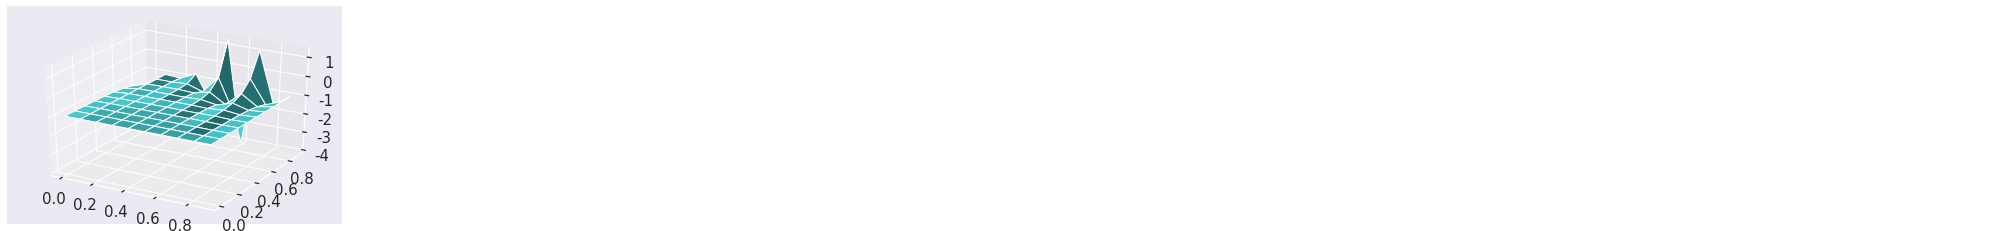

In [26]:
fig = plt.figure()
fig.figsize = (10, 10)

import matplotlib as mpl
mpl.rcParams['font.size'] = 15.0

ax = fig.gca(projection='3d')
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_zticklabels(np.arange(-4, 3, 1), fontsize = 15)
ax.plot_surface(xs, ys, z_1, rstride=1, cstride=1, linewidth=1, color='#46d1d6')
plt.show()